# Import Libraries

In [7]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchsummary import summary

# CIFAR-100 Mean and Std
cifar100_mean = (0.5071, 0.4865, 0.4409)
cifar100_std = (0.2673, 0.2564, 0.2761)
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [8]:


# Custom Albumentations Transform Wrapper
class AlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=(-7, 7), p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
            A.RandomCrop(height=28, width=28, p=0.5),
            A.Resize(height=32, width=32),
            A.CoarseDropout(
                max_holes=1,
                max_height=16, max_width=16,
                fill_value=tuple(int(m * 255) for m in mean),  # Convert mean to 0-255
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Instantiate transforms
train_transforms = AlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])

# CIFAR-100 Dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=5, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=5, pin_memory=True)


/tmp/ipython-input-2303470777.py:12: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


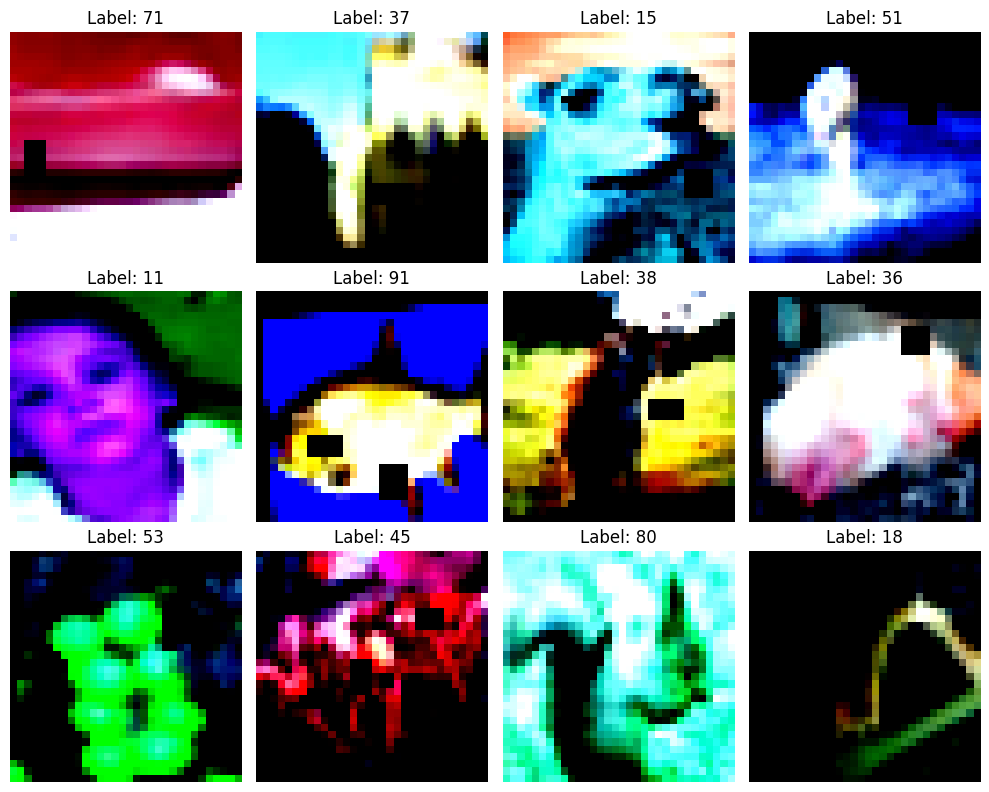

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get a batch
batch_data, batch_label = next(iter(train_loader))

# Move to CPU and detach the computation graph
batch_data = batch_data.cpu().detach()

fig = plt.figure(figsize=(10, 8))

for i in range(12):
    img = batch_data[i]  # shape: [3, 32, 32]
    img = img.numpy().transpose((1, 2, 0))  # to shape [32, 32, 3]
    img = np.clip(img, 0, 1)  # ensure valid range for display

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {batch_label[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Use GPU if available
# Load ResNet18 without pretrained weights
model = resnet18(weights=None, num_classes=100).to(device)

# Modify the final fully connected layer for CIFAR-100 (100 classes)
model.fc = nn.Linear(model.fc.in_features, 100)

# Move model to device
model = model.to(device)

# Print the summary (for CIFAR-100 input size)
summary(model, input_size=(3, 32, 32))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14      

In [11]:
def mixup_data(x, y, alpha=1.0, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import torch.nn.functional as F


# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True, mixup_alpha=0.4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
            outputs = model(inputs)
            loss = lam * F.cross_entropy(outputs, targets_a) + (1 - lam) * F.cross_entropy(outputs, targets_b)
        else:
            outputs = model(data)
            loss = F.cross_entropy(outputs, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accuracy tracking (still approximate when using MixUp)
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)

        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS = 40

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

Epoch 1 Loss=3.4221 Acc=14.92: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]



Test set: Average loss: 3.2998, Accuracy: 2028/10000 (20.28%)



Epoch 2 Loss=3.4910 Acc=18.87: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]



Test set: Average loss: 3.1236, Accuracy: 2349/10000 (23.49%)



Epoch 3 Loss=3.3535 Acc=22.10: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s]



Test set: Average loss: 3.0261, Accuracy: 2502/10000 (25.02%)



Epoch 4 Loss=3.2286 Acc=24.60: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 2.9580, Accuracy: 2744/10000 (27.44%)



Epoch 5 Loss=2.6924 Acc=27.50: 100%|██████████| 391/391 [00:30<00:00, 12.95it/s]



Test set: Average loss: 2.7870, Accuracy: 2991/10000 (29.91%)



Epoch 6 Loss=2.7445 Acc=30.46: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]



Test set: Average loss: 2.6035, Accuracy: 3402/10000 (34.02%)



Epoch 7 Loss=2.4460 Acc=32.97: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]



Test set: Average loss: 2.4771, Accuracy: 3616/10000 (36.16%)



Epoch 8 Loss=2.3339 Acc=35.59: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]



Test set: Average loss: 2.3704, Accuracy: 3859/10000 (38.59%)



Epoch 9 Loss=2.5520 Acc=38.20: 100%|██████████| 391/391 [00:30<00:00, 12.65it/s]



Test set: Average loss: 2.3657, Accuracy: 3872/10000 (38.72%)



Epoch 10 Loss=2.2250 Acc=40.52: 100%|██████████| 391/391 [00:30<00:00, 13.00it/s]



Test set: Average loss: 2.2985, Accuracy: 4087/10000 (40.87%)



Epoch 11 Loss=2.3408 Acc=42.45: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s]



Test set: Average loss: 2.1994, Accuracy: 4266/10000 (42.66%)



Epoch 12 Loss=2.0510 Acc=44.70: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s]



Test set: Average loss: 2.1202, Accuracy: 4453/10000 (44.53%)



Epoch 13 Loss=2.1098 Acc=46.50: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s]



Test set: Average loss: 2.1382, Accuracy: 4423/10000 (44.23%)



Epoch 14 Loss=2.0236 Acc=48.29: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s]



Test set: Average loss: 2.1053, Accuracy: 4550/10000 (45.50%)



Epoch 15 Loss=1.8044 Acc=49.52:  64%|██████▍   | 251/391 [00:20<00:11, 12.30it/s]


KeyboardInterrupt: 

In [12]:
# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True, mixup_alpha=0.4):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_data(data, target, alpha=mixup_alpha, device=device)
            outputs = model(inputs)
            loss = lam * F.cross_entropy(outputs, targets_a) + (1 - lam) * F.cross_entropy(outputs, targets_b)
        else:
            outputs = model(data)
            loss = F.cross_entropy(outputs, target)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accuracy tracking (still approximate when using MixUp)
        _, pred = outputs.max(1)
        if use_mixup:
            correct += lam * pred.eq(targets_a).sum().item() + (1 - lam) * pred.eq(targets_b).sum().item()
        else:
            correct += pred.eq(target).sum().item()
        processed += len(data)

        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

In [ ]:
# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS = 40

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

Epoch 1 Loss=4.1080 Acc=4.93: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 3.8700, Accuracy: 1146/10000 (11.46%)



Epoch 2 Loss=3.7708 Acc=8.33: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 3.6858, Accuracy: 1371/10000 (13.71%)



Epoch 3 Loss=3.8650 Acc=10.80: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 3.4331, Accuracy: 1931/10000 (19.31%)



Epoch 4 Loss=3.4393 Acc=13.67: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 3.2391, Accuracy: 2208/10000 (22.08%)



Epoch 5 Loss=3.2511 Acc=15.54: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]



Test set: Average loss: 3.0029, Accuracy: 2696/10000 (26.96%)



Epoch 6 Loss=4.1449 Acc=17.31: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 3.1769, Accuracy: 2445/10000 (24.45%)



Epoch 7 Loss=3.7653 Acc=19.57: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 2.9067, Accuracy: 2835/10000 (28.35%)



Epoch 8 Loss=2.9900 Acc=21.15: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 2.7548, Accuracy: 3121/10000 (31.21%)



Epoch 9 Loss=3.0817 Acc=23.03: 100%|██████████| 391/391 [00:33<00:00, 11.72it/s]



Test set: Average loss: 2.6914, Accuracy: 3391/10000 (33.91%)



Epoch 10 Loss=3.1194 Acc=24.09: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 2.6683, Accuracy: 3266/10000 (32.66%)



Epoch 11 Loss=2.6397 Acc=25.52: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s]



Test set: Average loss: 2.5892, Accuracy: 3535/10000 (35.35%)



Epoch 12 Loss=3.4141 Acc=27.16: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 2.5892, Accuracy: 3435/10000 (34.35%)



Epoch 13 Loss=3.0038 Acc=28.26: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 2.5131, Accuracy: 3670/10000 (36.70%)



Epoch 14 Loss=2.5250 Acc=30.06: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 2.4048, Accuracy: 3911/10000 (39.11%)



Epoch 15 Loss=3.3204 Acc=29.31: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s]



Test set: Average loss: 2.3810, Accuracy: 3953/10000 (39.53%)



Epoch 16 Loss=2.6870 Acc=31.37: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s]



Test set: Average loss: 2.2785, Accuracy: 4209/10000 (42.09%)



Epoch 17 Loss=2.0350 Acc=32.29: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]



Test set: Average loss: 2.2638, Accuracy: 4195/10000 (41.95%)



Epoch 18 Loss=3.5353 Acc=31.85: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s]



Test set: Average loss: 2.2711, Accuracy: 4211/10000 (42.11%)



Epoch 19 Loss=2.3673 Acc=34.05: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 2.2630, Accuracy: 4185/10000 (41.85%)



Epoch 20 Loss=2.4790 Acc=35.21: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]



Test set: Average loss: 2.2004, Accuracy: 4419/10000 (44.19%)



Epoch 21 Loss=2.1419 Acc=34.65: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 2.1757, Accuracy: 4424/10000 (44.24%)



Epoch 22 Loss=2.7917 Acc=36.62: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 2.1677, Accuracy: 4446/10000 (44.46%)



Epoch 23 Loss=2.2937 Acc=36.55: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 2.1410, Accuracy: 4523/10000 (45.23%)



Epoch 24 Loss=3.8063 Acc=37.75: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 2.1330, Accuracy: 4539/10000 (45.39%)



Epoch 25 Loss=2.1359 Acc=38.65: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 2.0854, Accuracy: 4642/10000 (46.42%)



Epoch 26 Loss=2.4483 Acc=39.53: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]



Test set: Average loss: 2.0427, Accuracy: 4759/10000 (47.59%)



Epoch 27 Loss=3.5080 Acc=39.19: 100%|██████████| 391/391 [00:33<00:00, 11.64it/s]



Test set: Average loss: 2.0551, Accuracy: 4742/10000 (47.42%)



Epoch 28 Loss=3.5178 Acc=41.78: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 1.9689, Accuracy: 4921/10000 (49.21%)



Epoch 29 Loss=2.9985 Acc=42.47: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 2.0152, Accuracy: 4847/10000 (48.47%)



Epoch 30 Loss=2.8367 Acc=43.20: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 1.9498, Accuracy: 4943/10000 (49.43%)



Epoch 31 Loss=2.3514 Acc=42.87: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 2.0660, Accuracy: 4857/10000 (48.57%)



Epoch 32 Loss=1.5283 Acc=45.01: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 1.9240, Accuracy: 5052/10000 (50.52%)



Epoch 33 Loss=1.6636 Acc=47.21: 100%|██████████| 391/391 [00:33<00:00, 11.54it/s]



Test set: Average loss: 1.9262, Accuracy: 5089/10000 (50.89%)



Epoch 34 Loss=2.5289 Acc=45.95: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]



Test set: Average loss: 1.8795, Accuracy: 5163/10000 (51.63%)



Epoch 35 Loss=3.3824 Acc=48.72: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]



Test set: Average loss: 1.8244, Accuracy: 5267/10000 (52.67%)



Epoch 36 Loss=3.0239 Acc=50.60: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 1.8451, Accuracy: 5234/10000 (52.34%)



Epoch 37 Loss=2.1382 Acc=52.40: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]



Test set: Average loss: 1.8164, Accuracy: 5307/10000 (53.07%)



Epoch 38 Loss=1.9740 Acc=53.36: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 1.7984, Accuracy: 5315/10000 (53.15%)



Epoch 39 Loss=3.7840 Acc=52.19: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]



Test set: Average loss: 1.8411, Accuracy: 5287/10000 (52.87%)



Epoch 40 Loss=1.4055 Acc=53.01: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 1.8010, Accuracy: 5344/10000 (53.44%)



In [9]:
# Use GPU if available
# Load ResNet18 without pretrained weights
model = resnet34(weights=None, num_classes=100).to(device)

# Modify the final fully connected layer for CIFAR-100 (100 classes)
model.fc = nn.Linear(model.fc.in_features, 100)

# Move model to device
model = model.to(device)

# Print the summary (for CIFAR-100 input size)
summary(model, input_size=(3, 32, 32))

# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS = 40

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Epoch 1 Loss=4.4827 Acc=3.83: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]



Test set: Average loss: 4.1112, Accuracy: 856/10000 (8.56%)



Epoch 2 Loss=4.6035 Acc=6.69: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 3.9845, Accuracy: 1241/10000 (12.41%)



Epoch 3 Loss=3.6625 Acc=8.88: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]



Test set: Average loss: 3.7173, Accuracy: 1471/10000 (14.71%)



Epoch 4 Loss=4.0104 Acc=11.02: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]



Test set: Average loss: 3.5019, Accuracy: 1825/10000 (18.25%)



Epoch 5 Loss=3.3945 Acc=13.36: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 3.4572, Accuracy: 2072/10000 (20.72%)



Epoch 6 Loss=3.4253 Acc=14.88: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]



Test set: Average loss: 3.0861, Accuracy: 2471/10000 (24.71%)



Epoch 7 Loss=3.4863 Acc=16.61: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 3.2807, Accuracy: 2569/10000 (25.69%)



Epoch 8 Loss=3.4991 Acc=18.12: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]



Test set: Average loss: 2.9569, Accuracy: 2661/10000 (26.61%)



Epoch 9 Loss=3.2083 Acc=19.63: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 2.9831, Accuracy: 2732/10000 (27.32%)



Epoch 10 Loss=3.6236 Acc=19.59: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]



Test set: Average loss: 2.9725, Accuracy: 2794/10000 (27.94%)



Epoch 11 Loss=3.0361 Acc=21.70: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]



Test set: Average loss: 2.7515, Accuracy: 3199/10000 (31.99%)



Epoch 12 Loss=2.8610 Acc=23.21: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]



Test set: Average loss: 2.8382, Accuracy: 3185/10000 (31.85%)



Epoch 13 Loss=2.6759 Acc=24.88: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]



Test set: Average loss: 2.7116, Accuracy: 3302/10000 (33.02%)



Epoch 14 Loss=3.2159 Acc=24.52: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]



Test set: Average loss: 2.6344, Accuracy: 3486/10000 (34.86%)



Epoch 15 Loss=2.8031 Acc=26.30: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]



Test set: Average loss: 2.5478, Accuracy: 3614/10000 (36.14%)



Epoch 16 Loss=2.4857 Acc=26.85: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s]



Test set: Average loss: 2.4559, Accuracy: 3714/10000 (37.14%)



Epoch 17 Loss=2.7070 Acc=28.73: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]



Test set: Average loss: 2.3927, Accuracy: 3927/10000 (39.27%)



Epoch 18 Loss=3.4180 Acc=29.12: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]



Test set: Average loss: 2.4061, Accuracy: 4018/10000 (40.18%)



Epoch 19 Loss=3.7059 Acc=30.07: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]



Test set: Average loss: 2.3484, Accuracy: 4032/10000 (40.32%)



Epoch 20 Loss=3.2391 Acc=30.30: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]



Test set: Average loss: 2.4004, Accuracy: 3938/10000 (39.38%)



Epoch 21 Loss=2.7848 Acc=31.44: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]



Test set: Average loss: 2.2915, Accuracy: 4156/10000 (41.56%)



Epoch 22 Loss=3.8998 Acc=28.61: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]



Test set: Average loss: 2.4277, Accuracy: 3855/10000 (38.55%)



Epoch 23 Loss=2.7942 Acc=30.66: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s]



Test set: Average loss: 2.5103, Accuracy: 3768/10000 (37.68%)



Epoch 24 Loss=2.6582 Acc=31.77: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]



Test set: Average loss: 2.3494, Accuracy: 4086/10000 (40.86%)



Epoch 25 Loss=3.1091 Acc=33.37: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s]



Test set: Average loss: 2.2785, Accuracy: 4204/10000 (42.04%)



Epoch 26 Loss=3.1837 Acc=35.63: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 2.1604, Accuracy: 4483/10000 (44.83%)



Epoch 27 Loss=2.1554 Acc=35.23: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]



Test set: Average loss: 2.1305, Accuracy: 4489/10000 (44.89%)



Epoch 28 Loss=3.1482 Acc=36.86: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s]



Test set: Average loss: 2.1319, Accuracy: 4561/10000 (45.61%)



Epoch 29 Loss=2.4366 Acc=36.86: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]



Test set: Average loss: 2.1457, Accuracy: 4558/10000 (45.58%)



Epoch 30 Loss=1.7643 Acc=39.06: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 2.0669, Accuracy: 4653/10000 (46.53%)



Epoch 31 Loss=3.3755 Acc=39.15: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 2.0430, Accuracy: 4758/10000 (47.58%)



Epoch 32 Loss=2.5172 Acc=40.66: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 2.0140, Accuracy: 4856/10000 (48.56%)



Epoch 33 Loss=1.9585 Acc=41.54: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 2.0351, Accuracy: 4855/10000 (48.55%)



Epoch 34 Loss=3.9218 Acc=42.01: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 2.0098, Accuracy: 4784/10000 (47.84%)



Epoch 35 Loss=3.9070 Acc=44.67: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 1.9673, Accuracy: 4930/10000 (49.30%)



Epoch 36 Loss=1.7384 Acc=44.02: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 1.9282, Accuracy: 5067/10000 (50.67%)



Epoch 37 Loss=2.1711 Acc=45.93: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 1.8829, Accuracy: 5118/10000 (51.18%)



Epoch 38 Loss=1.4311 Acc=46.15: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]



Test set: Average loss: 1.9013, Accuracy: 5101/10000 (51.01%)



Epoch 39 Loss=2.9695 Acc=46.72: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 1.9120, Accuracy: 5087/10000 (50.87%)



Epoch 40 Loss=1.8613 Acc=48.24: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 1.8892, Accuracy: 5117/10000 (51.17%)



In [6]:
# Use GPU if available
# Load ResNet34 without pretrained weights
model = resnet34(weights=None, num_classes=100).to(device)

# Modify the final fully connected layer for CIFAR-100 (100 classes)
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Reduced from 0.4
    nn.Linear(model.fc.in_features, 100),
)

# Move model to device
model = model.to(device)

# Print the summary (for CIFAR-100 input size)
summary(model, input_size=(3, 32, 32))

# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
EPOCHS = 100

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Epoch 1 Loss=4.3799 Acc=2.51: 100%|██████████| 391/391 [00:44<00:00,  8.88it/s]



Test set: Average loss: 4.1688, Accuracy: 681/10000 (6.81%)



Epoch 2 Loss=4.5202 Acc=5.36: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 3.9373, Accuracy: 973/10000 (9.73%)



Epoch 3 Loss=4.3829 Acc=7.54: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s]



Test set: Average loss: 3.7438, Accuracy: 1277/10000 (12.77%)



Epoch 4 Loss=3.8694 Acc=9.10: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 3.6791, Accuracy: 1460/10000 (14.60%)



Epoch 5 Loss=4.0065 Acc=10.60: 100%|██████████| 391/391 [00:41<00:00,  9.43it/s]



Test set: Average loss: 3.5067, Accuracy: 1686/10000 (16.86%)



Epoch 6 Loss=4.0046 Acc=11.90: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s]



Test set: Average loss: 3.3699, Accuracy: 1933/10000 (19.33%)



Epoch 7 Loss=3.9693 Acc=12.62: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]



Test set: Average loss: 3.3905, Accuracy: 1945/10000 (19.45%)



Epoch 8 Loss=4.2293 Acc=14.76: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]



Test set: Average loss: 3.2141, Accuracy: 2239/10000 (22.39%)



Epoch 9 Loss=3.3406 Acc=15.65: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]



Test set: Average loss: 3.2587, Accuracy: 2356/10000 (23.56%)



Epoch 10 Loss=3.8494 Acc=16.28: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 3.0697, Accuracy: 2647/10000 (26.47%)



Epoch 11 Loss=2.9224 Acc=18.33: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]



Test set: Average loss: 2.9142, Accuracy: 2813/10000 (28.13%)



Epoch 12 Loss=2.8306 Acc=19.20: 100%|██████████| 391/391 [00:41<00:00,  9.40it/s]



Test set: Average loss: 2.9173, Accuracy: 2884/10000 (28.84%)



Epoch 13 Loss=3.2951 Acc=18.31: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]



Test set: Average loss: 2.8328, Accuracy: 3086/10000 (30.86%)



Epoch 14 Loss=3.3308 Acc=20.09: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s]



Test set: Average loss: 2.8272, Accuracy: 3025/10000 (30.25%)



Epoch 15 Loss=3.5174 Acc=20.95: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 2.8881, Accuracy: 3004/10000 (30.04%)



Epoch 16 Loss=2.9290 Acc=21.54: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]



Test set: Average loss: 2.7135, Accuracy: 3266/10000 (32.66%)



Epoch 17 Loss=4.5659 Acc=22.74: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s]



Test set: Average loss: 3.5451, Accuracy: 2403/10000 (24.03%)



Epoch 18 Loss=2.7465 Acc=22.99: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]



Test set: Average loss: 2.6341, Accuracy: 3460/10000 (34.60%)



Epoch 19 Loss=4.0916 Acc=24.29: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 2.6477, Accuracy: 3386/10000 (33.86%)



Epoch 20 Loss=3.0524 Acc=23.54: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 2.7336, Accuracy: 3299/10000 (32.99%)



Epoch 21 Loss=3.4789 Acc=24.79: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 2.7697, Accuracy: 3211/10000 (32.11%)



Epoch 22 Loss=3.4858 Acc=24.69: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]



Test set: Average loss: 2.4957, Accuracy: 3698/10000 (36.98%)



Epoch 23 Loss=2.8586 Acc=25.83: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]



Test set: Average loss: 2.4876, Accuracy: 3684/10000 (36.84%)



Epoch 24 Loss=3.0457 Acc=25.51: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s]



Test set: Average loss: 2.5677, Accuracy: 3533/10000 (35.33%)



Epoch 25 Loss=3.1707 Acc=25.93: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 2.5394, Accuracy: 3639/10000 (36.39%)



Epoch 26 Loss=3.6851 Acc=27.21: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s]



Test set: Average loss: 2.3594, Accuracy: 4024/10000 (40.24%)



Epoch 27 Loss=2.6827 Acc=28.31: 100%|██████████| 391/391 [00:41<00:00,  9.41it/s]



Test set: Average loss: 2.3742, Accuracy: 3998/10000 (39.98%)



Epoch 28 Loss=3.8015 Acc=28.51: 100%|██████████| 391/391 [00:41<00:00,  9.52it/s]



Test set: Average loss: 2.4288, Accuracy: 3974/10000 (39.74%)



Epoch 29 Loss=3.2550 Acc=28.76: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 2.3688, Accuracy: 3981/10000 (39.81%)



Epoch 30 Loss=2.9683 Acc=29.64: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s]



Test set: Average loss: 2.5318, Accuracy: 3643/10000 (36.43%)



Epoch 31 Loss=2.4178 Acc=29.93: 100%|██████████| 391/391 [00:42<00:00,  9.23it/s]



Test set: Average loss: 2.2979, Accuracy: 4180/10000 (41.80%)



Epoch 32 Loss=3.1465 Acc=30.26: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s]



Test set: Average loss: 2.3080, Accuracy: 4197/10000 (41.97%)



Epoch 33 Loss=2.9337 Acc=30.40: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]



Test set: Average loss: 2.2948, Accuracy: 4230/10000 (42.30%)



Epoch 34 Loss=3.9369 Acc=31.51: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s]



Test set: Average loss: 2.2935, Accuracy: 4318/10000 (43.18%)



Epoch 35 Loss=3.3666 Acc=31.93: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s]



Test set: Average loss: 2.2430, Accuracy: 4277/10000 (42.77%)



Epoch 36 Loss=2.4794 Acc=32.38: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 2.2610, Accuracy: 4192/10000 (41.92%)



Epoch 37 Loss=2.3344 Acc=32.57: 100%|██████████| 391/391 [00:41<00:00,  9.33it/s]



Test set: Average loss: 2.1729, Accuracy: 4538/10000 (45.38%)



Epoch 38 Loss=2.1040 Acc=32.38: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]



Test set: Average loss: 2.2218, Accuracy: 4446/10000 (44.46%)



Epoch 39 Loss=3.5264 Acc=32.99: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 2.2514, Accuracy: 4344/10000 (43.44%)



Epoch 40 Loss=2.2446 Acc=35.09: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s]



Test set: Average loss: 2.2422, Accuracy: 4320/10000 (43.20%)



Epoch 41 Loss=3.8598 Acc=33.25: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 2.2388, Accuracy: 4396/10000 (43.96%)



Epoch 42 Loss=2.5827 Acc=34.13: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 2.2483, Accuracy: 4434/10000 (44.34%)



Epoch 43 Loss=2.0486 Acc=34.33: 100%|██████████| 391/391 [00:42<00:00,  9.31it/s]



Test set: Average loss: 2.1333, Accuracy: 4567/10000 (45.67%)



Epoch 44 Loss=2.2229 Acc=34.55: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s]



Test set: Average loss: 2.2052, Accuracy: 4471/10000 (44.71%)



Epoch 45 Loss=2.1908 Acc=33.92: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s]



Test set: Average loss: 2.2709, Accuracy: 4312/10000 (43.12%)



Epoch 46 Loss=3.2081 Acc=34.45: 100%|██████████| 391/391 [00:41<00:00,  9.41it/s]



Test set: Average loss: 2.2474, Accuracy: 4415/10000 (44.15%)



Epoch 47 Loss=2.7093 Acc=34.39: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 2.2537, Accuracy: 4340/10000 (43.40%)



Epoch 48 Loss=3.1718 Acc=35.69: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 2.1510, Accuracy: 4611/10000 (46.11%)



Epoch 49 Loss=2.1665 Acc=35.91: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]



Test set: Average loss: 2.1414, Accuracy: 4594/10000 (45.94%)



Epoch 50 Loss=2.1711 Acc=35.05: 100%|██████████| 391/391 [00:40<00:00,  9.54it/s]



Test set: Average loss: 2.1616, Accuracy: 4518/10000 (45.18%)



Epoch 51 Loss=3.0735 Acc=36.35: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]



Test set: Average loss: 2.0697, Accuracy: 4684/10000 (46.84%)



Epoch 52 Loss=3.7749 Acc=37.25: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]



Test set: Average loss: 2.0793, Accuracy: 4698/10000 (46.98%)



Epoch 53 Loss=2.4492 Acc=35.29: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 2.1058, Accuracy: 4733/10000 (47.33%)



Epoch 54 Loss=2.3862 Acc=37.41: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 2.0244, Accuracy: 4832/10000 (48.32%)



Epoch 55 Loss=2.2049 Acc=37.46: 100%|██████████| 391/391 [00:41<00:00,  9.52it/s]



Test set: Average loss: 2.1307, Accuracy: 4588/10000 (45.88%)



Epoch 56 Loss=3.1165 Acc=37.36: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]



Test set: Average loss: 2.1215, Accuracy: 4599/10000 (45.99%)



Epoch 57 Loss=3.6416 Acc=37.94: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]



Test set: Average loss: 2.0591, Accuracy: 4808/10000 (48.08%)



Epoch 58 Loss=1.9130 Acc=38.91: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]



Test set: Average loss: 2.0804, Accuracy: 4743/10000 (47.43%)



Epoch 59 Loss=2.1427 Acc=37.25: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s]



Test set: Average loss: 2.0130, Accuracy: 4931/10000 (49.31%)



Epoch 60 Loss=2.0129 Acc=37.84: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 2.1066, Accuracy: 4645/10000 (46.45%)



Epoch 61 Loss=1.9860 Acc=38.76: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 2.0426, Accuracy: 4795/10000 (47.95%)



Epoch 62 Loss=1.7882 Acc=39.43: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]



Test set: Average loss: 2.0772, Accuracy: 4733/10000 (47.33%)



Epoch 63 Loss=3.5100 Acc=39.15: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]



Test set: Average loss: 2.0859, Accuracy: 4833/10000 (48.33%)



Epoch 64 Loss=3.6269 Acc=39.67: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]



Test set: Average loss: 2.1337, Accuracy: 4684/10000 (46.84%)



Epoch 65 Loss=3.6836 Acc=40.65: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s]



Test set: Average loss: 2.0173, Accuracy: 4872/10000 (48.72%)



Epoch 66 Loss=2.0294 Acc=40.22: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]



Test set: Average loss: 1.9657, Accuracy: 5055/10000 (50.55%)



Epoch 67 Loss=1.8870 Acc=40.75: 100%|██████████| 391/391 [00:41<00:00,  9.52it/s]



Test set: Average loss: 1.9962, Accuracy: 4923/10000 (49.23%)



Epoch 68 Loss=1.8706 Acc=40.86: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]



Test set: Average loss: 1.9599, Accuracy: 4941/10000 (49.41%)



Epoch 69 Loss=3.6456 Acc=41.51: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s]



Test set: Average loss: 1.9620, Accuracy: 5022/10000 (50.22%)



Epoch 70 Loss=2.1718 Acc=41.91: 100%|██████████| 391/391 [00:44<00:00,  8.72it/s]



Test set: Average loss: 1.9751, Accuracy: 5048/10000 (50.48%)



Epoch 71 Loss=2.0582 Acc=42.55: 100%|██████████| 391/391 [00:44<00:00,  8.80it/s]



Test set: Average loss: 1.9131, Accuracy: 5084/10000 (50.84%)



Epoch 72 Loss=3.5524 Acc=42.70: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]



Test set: Average loss: 1.9225, Accuracy: 5226/10000 (52.26%)



Epoch 73 Loss=3.0034 Acc=43.34: 100%|██████████| 391/391 [00:42<00:00,  9.20it/s]



Test set: Average loss: 1.9233, Accuracy: 5068/10000 (50.68%)



Epoch 74 Loss=3.4818 Acc=42.95: 100%|██████████| 391/391 [00:42<00:00,  9.22it/s]



Test set: Average loss: 2.0065, Accuracy: 4995/10000 (49.95%)



Epoch 75 Loss=1.3507 Acc=44.97: 100%|██████████| 391/391 [00:41<00:00,  9.42it/s]



Test set: Average loss: 1.8126, Accuracy: 5321/10000 (53.21%)



Epoch 76 Loss=2.3392 Acc=43.39: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]



Test set: Average loss: 1.9133, Accuracy: 5184/10000 (51.84%)



Epoch 77 Loss=1.8452 Acc=45.37: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 1.8016, Accuracy: 5338/10000 (53.38%)



Epoch 78 Loss=2.3698 Acc=46.18: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s]



Test set: Average loss: 1.8664, Accuracy: 5291/10000 (52.91%)



Epoch 79 Loss=2.0112 Acc=46.78: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s]



Test set: Average loss: 1.7717, Accuracy: 5466/10000 (54.66%)



Epoch 80 Loss=3.1143 Acc=47.15: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s]



Test set: Average loss: 1.7864, Accuracy: 5401/10000 (54.01%)



Epoch 81 Loss=1.7036 Acc=47.97: 100%|██████████| 391/391 [00:40<00:00,  9.54it/s]



Test set: Average loss: 1.7535, Accuracy: 5453/10000 (54.53%)



Epoch 82 Loss=2.2882 Acc=48.71: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]



Test set: Average loss: 1.8205, Accuracy: 5354/10000 (53.54%)



Epoch 83 Loss=2.7484 Acc=47.92: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s]



Test set: Average loss: 1.7411, Accuracy: 5522/10000 (55.22%)



Epoch 84 Loss=3.1927 Acc=51.38: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]



Test set: Average loss: 1.7520, Accuracy: 5504/10000 (55.04%)



Epoch 85 Loss=1.1969 Acc=50.61: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]



Test set: Average loss: 1.7187, Accuracy: 5575/10000 (55.75%)



Epoch 86 Loss=1.3540 Acc=52.66: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]



Test set: Average loss: 1.7203, Accuracy: 5598/10000 (55.98%)



Epoch 87 Loss=1.0356 Acc=51.35: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s]



Test set: Average loss: 1.6858, Accuracy: 5702/10000 (57.02%)



Epoch 88 Loss=2.2885 Acc=55.39: 100%|██████████| 391/391 [00:41<00:00,  9.37it/s]



Test set: Average loss: 1.7118, Accuracy: 5647/10000 (56.47%)



Epoch 89 Loss=0.9146 Acc=54.32: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s]



Test set: Average loss: 1.7232, Accuracy: 5686/10000 (56.86%)



Epoch 90 Loss=0.9410 Acc=58.00: 100%|██████████| 391/391 [00:41<00:00,  9.32it/s]



Test set: Average loss: 1.6589, Accuracy: 5787/10000 (57.87%)



Epoch 91 Loss=1.7641 Acc=58.11: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s]



Test set: Average loss: 1.6800, Accuracy: 5720/10000 (57.20%)



Epoch 92 Loss=1.1965 Acc=56.87: 100%|██████████| 391/391 [00:42<00:00,  9.19it/s]



Test set: Average loss: 1.6840, Accuracy: 5755/10000 (57.55%)



Epoch 93 Loss=2.5605 Acc=59.29: 100%|██████████| 391/391 [00:42<00:00,  9.29it/s]



Test set: Average loss: 1.6773, Accuracy: 5786/10000 (57.86%)



Epoch 94 Loss=1.0247 Acc=60.72: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]



Test set: Average loss: 1.6394, Accuracy: 5845/10000 (58.45%)



Epoch 95 Loss=0.6151 Acc=60.79: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s]



Test set: Average loss: 1.6338, Accuracy: 5847/10000 (58.47%)



Epoch 96 Loss=1.4532 Acc=59.25: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]



Test set: Average loss: 1.6430, Accuracy: 5810/10000 (58.10%)



Epoch 97 Loss=0.9922 Acc=63.59: 100%|██████████| 391/391 [00:43<00:00,  9.00it/s]



Test set: Average loss: 1.6142, Accuracy: 5895/10000 (58.95%)



Epoch 98 Loss=0.6722 Acc=63.77: 100%|██████████| 391/391 [00:43<00:00,  9.08it/s]



Test set: Average loss: 1.6513, Accuracy: 5851/10000 (58.51%)



Epoch 99 Loss=0.5311 Acc=63.55: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s]



Test set: Average loss: 1.6290, Accuracy: 5859/10000 (58.59%)



Epoch 100 Loss=3.0378 Acc=64.39: 100%|██████████| 391/391 [00:42<00:00,  9.27it/s]



Test set: Average loss: 1.6370, Accuracy: 5872/10000 (58.72%)



In [ ]:
# Use GPU if available
# Load ResNet18 without pretrained weights
model = resnet18(weights=None, num_classes=100).to(device)

# Modify the final fully connected layer for CIFAR-100 (100 classes)
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # Reduced from 0.4
    nn.Linear(model.fc.in_features, 100),
)

# Move model to device
model = model.to(device)

# Print the summary (for CIFAR-100 input size)
summary(model, input_size=(3, 32, 32))

# ------------------------------
# Run Training
# ------------------------------
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
EPOCHS = 100

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch, use_mixup=True)
    acc = test(model, device, test_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

Epoch 1 Loss=4.5250 Acc=2.60:  58%|█████▊    | 226/391 [00:21<00:19,  8.68it/s]

# Improvements to Reach 74% Test Accuracy

## Analysis of Previous Runs:
- **40 epochs run (cell-5)**: Peak test accuracy 53.44% without proper MixUp training
- **150 epochs run (new_trial)**: Peak test accuracy 55.78% but severe overfitting (train 73%+ vs test 55%)

## Key Issues Identified:
1. **Model capacity too small** - ResNet18 (11.2M params) insufficient for 100 classes
2. **MixUp too aggressive** - Alpha=0.4 causing performance degradation
3. **Data augmentation overlap** - ColorJitter + RandomBrightnessContrast + HueSaturationValue are redundant
4. **Training plateaued** - Model maxed out at ~56% accuracy

## Improvements Implemented Below:

### 1. Model Architecture: ResNet18 → ResNet34
- **Parameters**: 11.2M → 21.3M (nearly 2x capacity)
- **Depth**: 18 layers → 34 layers
- Better feature learning for 100-class classification

### 2. MixUp Tuning: Alpha 0.4 → 0.2
- Less aggressive blending
- Previous runs showed MixUp hurt performance
- Lower alpha = more focused training

### 3. Simplified Data Augmentation
**Removed:**
- ColorJitter (redundant)
- RandomBrightnessContrast (redundant)
- HueSaturationValue (too aggressive)

**Kept:**
- HorizontalFlip (standard)
- Affine (translation, scale, rotation)
- RandomCrop + Resize
- CoarseDropout (cutout)
- Normalize

### 4. Extended Training: 100 Epochs
- More time for convergence
- OneCycleLR for learning rate scheduling

In [7]:
# Simplified Data Augmentation (Removed redundant color transforms)
class SimplifiedAlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Affine(translate_percent=0.0625, scale=(0.9, 1.1), rotate=(-7, 7), p=0.5),
            A.RandomCrop(height=28, width=28, p=0.5),
            A.Resize(height=32, width=32),
            A.CoarseDropout(
                max_holes=1,
                max_height=16, max_width=16,
                fill_value=tuple(int(m * 255) for m in mean),
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, img):
        image = np.array(img)
        return self.aug(image=image)["image"]

# Create new datasets with simplified augmentations
train_transforms_v2 = SimplifiedAlbumentationsTransforms(mean=cifar100_mean, std=cifar100_std)
train_dataset_v2 = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms_v2)
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar100_mean, std=cifar100_std)
])
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=5, pin_memory=True)

print("Simplified augmentation pipeline created!")
print("Removed: ColorJitter, RandomBrightnessContrast, HueSaturationValue")
print("Kept: HorizontalFlip, Affine, RandomCrop, CoarseDropout")

/tmp/ipython-input-624767531.py:9: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Simplified augmentation pipeline created!
Removed: ColorJitter, RandomBrightnessContrast, HueSaturationValue
Kept: HorizontalFlip, Affine, RandomCrop, CoarseDropout


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Initialize ResNet34 for CIFAR-100
model_v2 = resnet34(weights=None, num_classes=100).to(device)

print("=" * 70)
print("Model Upgrade: ResNet18 → ResNet34")
print("=" * 70)
summary(model_v2, input_size=(3, 32, 32))

Model Upgrade: ResNet18 → ResNet34
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
    

In [9]:
# Training with Improved Configuration
# Key changes: ResNet34, Reduced MixUp (alpha=0.2), Simplified augmentation, 100 epochs

optimizer_v2 = optim.SGD(model_v2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
EPOCHS_V2 = 40

scheduler_v2 = OneCycleLR(
    optimizer_v2,
    max_lr=0.05,
    steps_per_epoch=len(train_loader_v2),
    epochs=EPOCHS_V2
)

print("=" * 70)
print("Training Configuration:")
print("=" * 70)
print(f"Model: ResNet34 (21.3M parameters)")
print(f"MixUp Alpha: 0.2 (reduced from 0.4)")
print(f"Epochs: {EPOCHS_V2}")
print(f"Optimizer: SGD (lr=0.01, momentum=0.9, weight_decay=1e-4)")
print(f"Scheduler: OneCycleLR (max_lr=0.05)")
print(f"Data Augmentation: Simplified (removed redundant color transforms)")
print("=" * 70)
print()

best_acc = 0.0
for epoch in range(1, EPOCHS_V2 + 1):
    train(model_v2, device, train_loader_v2, optimizer_v2, scheduler_v2, epoch, use_mixup=True, mixup_alpha=0.2)
    acc = test(model_v2, device, test_loader)

    if acc > best_acc:
        best_acc = acc
        print(f"*** New best accuracy: {best_acc:.2f}% ***")

    # Early stopping if target reached
    if acc >= 74.0:
        print(f"\n{'=' * 70}")
        print(f"Target accuracy of 74% reached at epoch {epoch}!")
        print(f"Final test accuracy: {acc:.2f}%")
        print(f"{'=' * 70}")
        break

print(f"\nTraining completed. Best test accuracy: {best_acc:.2f}%")

Training Configuration:
Model: ResNet34 (21.3M parameters)
MixUp Alpha: 0.2 (reduced from 0.4)
Epochs: 40
Optimizer: SGD (lr=0.01, momentum=0.9, weight_decay=1e-4)
Scheduler: OneCycleLR (max_lr=0.05)
Data Augmentation: Simplified (removed redundant color transforms)



Epoch 1 Loss=3.7487 Acc=6.66: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s]



Test set: Average loss: 3.8757, Accuracy: 1100/10000 (11.00%)

*** New best accuracy: 11.00% ***


Epoch 2 Loss=3.7514 Acc=12.25: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]



Test set: Average loss: 3.6104, Accuracy: 1564/10000 (15.64%)

*** New best accuracy: 15.64% ***


Epoch 3 Loss=3.8730 Acc=15.47: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s]



Test set: Average loss: 3.4190, Accuracy: 1977/10000 (19.77%)

*** New best accuracy: 19.77% ***


Epoch 4 Loss=3.2073 Acc=18.16: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s]



Test set: Average loss: 3.2032, Accuracy: 2318/10000 (23.18%)

*** New best accuracy: 23.18% ***


Epoch 5 Loss=3.1162 Acc=20.67: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 3.4802, Accuracy: 2391/10000 (23.91%)

*** New best accuracy: 23.91% ***


Epoch 6 Loss=2.8163 Acc=22.98: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]



Test set: Average loss: 2.8450, Accuracy: 3056/10000 (30.56%)

*** New best accuracy: 30.56% ***


Epoch 7 Loss=2.8000 Acc=25.68: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 2.7288, Accuracy: 3188/10000 (31.88%)

*** New best accuracy: 31.88% ***


Epoch 8 Loss=2.5254 Acc=27.74: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 2.8832, Accuracy: 3243/10000 (32.43%)

*** New best accuracy: 32.43% ***


Epoch 9 Loss=3.2784 Acc=30.23: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]



Test set: Average loss: 2.6290, Accuracy: 3554/10000 (35.54%)

*** New best accuracy: 35.54% ***


Epoch 10 Loss=3.0043 Acc=32.03: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 2.5623, Accuracy: 3427/10000 (34.27%)



Epoch 11 Loss=2.5393 Acc=33.66: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 2.3158, Accuracy: 4028/10000 (40.28%)

*** New best accuracy: 40.28% ***


Epoch 12 Loss=2.8353 Acc=35.59: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]



Test set: Average loss: 2.3719, Accuracy: 3867/10000 (38.67%)



Epoch 13 Loss=3.8075 Acc=36.64: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 2.4736, Accuracy: 3961/10000 (39.61%)



Epoch 14 Loss=3.1262 Acc=38.18: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 2.2981, Accuracy: 4110/10000 (41.10%)

*** New best accuracy: 41.10% ***


Epoch 15 Loss=3.5747 Acc=39.54: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 2.2715, Accuracy: 4179/10000 (41.79%)

*** New best accuracy: 41.79% ***


Epoch 16 Loss=2.4041 Acc=41.79:  17%|█▋        | 65/391 [00:05<00:28, 11.58it/s]Exception in thread Thread-35 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.det

KeyboardInterrupt: 